# Setup the PEST(++) interface around the modified Freyberg model

In this notebook, we will construct a complex model independent (non-intrusive) interface around an existing `MODFLOW6` model using `pyEMU`. We assume that the reader is at least partially familiar with PEST(++) file formats and working philosophy. 

The modified Freyberg groundwater flow model has been constructed and is described in a previous notebook from this series (see ["intro freyberg model"](../part0_02_intro_to_freyberg_model/intro_freyberg_model.ipynb)). We will construct the entire PEST(++) interface from scratch here. This setup will be built upon in subsequent tutorials. 

We will rely heavily on the `pyemu.PstFrom` class. Although here we employ it with a `MODFLOW6` model, `PstFrom` is designed to be general and software independent (mostly). Some features are only available for `MODFLOW` models (e.g. `SpatialReference`).

The `PstFrom` class automates the construction of high-dimensional PEST(++) interfaces with all the bells and whistles. It provides easy-to-use functions to process model input and output files into PEST(++) datasets. It can assist with setting up spatio-temporally varying parameters. It handles the generation of geostatistical prior covariance matrices and ensembles. It automates writing a "model run" script. It provides tools to add custom pre- and post-processing functions to this script. It makes adding tweaks and fixes to the PEST(++) interface a breeze. All of this from the comfort of your favorite Python IDE.

You may also wish to go through the ["intro to pyemu"](../part0_intro_to_pyemu/intro_to_pyemu.ipynb) and ["pstfrom sneakpeak"](../part1_02_pest_setup/pstfrom_sneakpeak.ipynb) notebooks to get an overview of `pyemu` and a slim-downed `PstFrom` example.

During this tutorial we are going to construct a PEST dataset. Amongst other things, we will demonstrate:
 - how to add observations & parameters from model output & input files;
 - how to add pre- and post-processing functions to the "model run" script;
 - how to generate geostatistical structures for spatially and temporally correlated parameters;
 - how to edit parameter/observation data sections;
 - how to generate a prior parameter covariance matrix and prior parameter ensemble;



First, let's get our model files and sort out some admin.


### Admin & Organize Folders
First some admin. Load the dependencies and organize model folders. 

In [1]:
import sys
import os
import shutil
import platform
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
# for this course we use locally stored version of pyemu and flopy to avoid version conflicts
import pyemu
import flopy
#assert "dependencies" in flopy.__file__
#assert "dependencies" in pyemu.__file__
# herebedragons.py contains a series of utility functions that help us manage the tutorial repository
sys.path.insert(0,"..")
import herebedragons as hbd

We will be calling a few external programs throughout this tutorial. Namely, MODFLOW 6 and PESTPP-GLM. For the purposes of the tutorial(s), we have included executables in the tutorial repository. They are in the `bin_new` folder, organized by operating system and will be programmatically copied into the working dirs as needed. 

Some may prefer that executables be located in a folder that is cited in your computer's PATH environment variable. Doing so allows you to run them from a command prompt open to any other folder without having to include the full path to these executables in the command to run them. 

However, in situations where someone has several active projects and each may use difference versions of compiled binary codes, this may not be practical. In such cases, we can simply place the executables in the folder from which they will be executed.  So, let's copy the necessary executables into our working folder using a simple helper function:


Let's copy the original model folder into a new working directory, just to ensure we don't mess up the base files.

In [2]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')

# a dir to hold a copy of the org model files
tmp_d = os.path.join('freyberg_mf6')

if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)
shutil.copytree(org_d,tmp_d)

# get executables
hbd.prep_bins(tmp_d)
# get dependency folders
hbd.prep_deps(tmp_d)

If you inspect the model folder, you will see that all the `MODFLOW6` model files have been written "externally". This is key for working with the `PstFrom` class (or with PEST(++) in general, really). Essentially, all pertinent model inputs have been written as independent files in either array or list format. This makes it easier for us to programmatically access and re-write the values in these files.

Array files contain a data type (usually floating points). List files will have a few columns that contain index information and then columns of floating point values (they have a tabular format; think `.csv` files or DataFrames). The `PstFrom` class provides methods for processing these file types into a PEST(++) dataset. 



In [3]:
os.listdir(tmp_d)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.gwfgwt',
 'freyberg6.ic',
 'freyberg6.ic_conc_strt_layer1.txt',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.obs',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyberg6.rch_recharge_11.txt',
 'freyberg6.rch_recharge_12.txt',
 'freyberg6.rch_recharge_13.txt',
 'freyberg6.rch_recharge_14.txt',
 'freyberg6.rch_recharge_15.txt',
 'freyberg6.rch_recharge_16.txt',
 'freyberg6.rch_recharge_17.txt',
 'freyberg6.rch_recharge_18.txt',
 'freyberg6.rch_recharge_19.txt',
 'freyberg6.rch_recharge_2.txt',
 'fre

Now we need just a tiny bit of info about the spatial discretization of the model - this is needed to work out separation distances between parameters to build a geostatistical prior covariance matrix later.

Here we will load the flopy sim and model instance just to help us define some quantities later - flopy is ***not required*** to use the `PstFrom` class. ***Neither is MODFLOW***. However, at the time of writing, support for `SpatialReference` to spatially locate parameters is limited to structured grid models.

Load the simulation. Run it once to make sure it works and to ***make sure that model output files are in the folder***. 

In [4]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d)
# load flow model
gwf = sim.get_model()

# run the model once to make sure it works
pyemu.os_utils.run("mf6",cwd=tmp_d)
# run modpath7
pyemu.os_utils.run(r'mp7 freyberg_mp.mpsim', cwd=tmp_d)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...
    loading package obs...
  loading solution package freyberg6...
mf6.exe
mp7.exe freyberg_mp.mpsim


### Spatial Reference
Now we can instantiate a `SpatialReference`. This will later be passed to `PstFrom` to assist with spatially locating parameters (e.g. pilot points and/or cell-by-cell parameters).  You can also use the flopy `modelgrid` class instance that is attached to the simulation, but `SpatialReference` is cleaner and faster for structured grids...

In [5]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_d, "freyberg6.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)
sr

   could not remove start_datetime


xul:0; yul:10000; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

### Instantiate PstFrom

Now we can start to construct the PEST(++) interface by instantiating a `PstFrom` class instance. There are a few things that we need to specify up front:

 - the folder in which we currently have model files (e.g. `tmp_d`). PstFrom will copy all the files from this directory into a new "template" folder.
 - **template folder**: this is a folder in which the PEST dataset will be constructed - this folder will hold the model files plus all of the files needed to run PEST(++). This folder/dataset will form the template for subsequent deployment of PEST(++).
 - **longnames**: for backwards compatibility with PEST and PEST_HP (i.e. non-PEST++ versions), which have upper limits to parameter/observation names (PEST++ does not). Setting this value to False is only recommended if required. 
 - Whether the model is `zero based` or not.
 - (optional) the **spatial reference**, as previously discussed. This is only required if using `pyEMU` to define parameter spatial correlation. Alternatively, you can define these yourself or use utilities available in the PEST-suite. 

In [6]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join("freyberg6_template")
start_datetime="1-1-2008"
# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=tmp_d, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=True, # set False if using PEST/PEST_HP
                            spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime=start_datetime, # required when specifying temporal correlation between parameters
                            echo=False) # to stop PstFrom from writting lots of infromation to the notebook; experiment by setting it as True to see the difference; usefull for troubleshooting

In [7]:
os.listdir(template_ws)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.gwfgwt',
 'freyberg6.ic',
 'freyberg6.ic_conc_strt_layer1.txt',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.obs',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyberg6.rch_recharge_11.txt',
 'freyberg6.rch_recharge_12.txt',
 'freyberg6.rch_recharge_13.txt',
 'freyberg6.rch_recharge_14.txt',
 'freyberg6.rch_recharge_15.txt',
 'freyberg6.rch_recharge_16.txt',
 'freyberg6.rch_recharge_17.txt',
 'freyberg6.rch_recharge_18.txt',
 'freyberg6.rch_recharge_19.txt',
 'freyberg6.rch_recharge_2.txt',
 'fre

So we see that when `PstFrom` is instantiated, it starts by copying the `original_d` to the `new_d`.  sweet as!

### Observations

We now have a `PstFrom` instance assigned to the variable `pf`. For now it is only an empty container to which we can start adding "observations", "parameters" and other bits and bobs.

Let's start with observations because they are easier. `MODFLOW6` makes life even easier by recording observations in nicely organized .csv files. Isn't that a peach!

#### Freyberg Recap
As you may recall from the "*intro to Freyberg*" tutorial, the model is configured to record time series of head at observation wells, and flux at three locations along the river. These are recorded in external .csv files named `heads.csv` and `sfr.csv`, respectively. You should be able to see these files in the model folder.

Recall that each .csv houses records of observation time-series. Outputs are recorded for each simulated stress-period. The model starts with a single steady-state stress-period, followed by 24 monthly transient stress-periods. The steady-state and first 12 transient stress-periods simulate the history-matching period. The last 12 transient stress periods simulate future conditions (i.e. the prediction period).

In [8]:
# check the output csv file names
for i in gwf.obs:
    print(i.output.obs_names)

['sfr.csv']
['heads.csv']


Let's start with the 'heads.csv' file. First load it as a DataFrame to take a look:

In [9]:
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)
df.head()

,TRGW-0-2-15,TRGW-0-2-9,TRGW-0-3-8,TRGW-0-9-1,TRGW-0-13-10,TRGW-0-15-16,TRGW-0-21-10,TRGW-0-22-15,TRGW-0-24-4,TRGW-0-26-6,TRGW-0-29-15,TRGW-0-33-7,TRGW-0-34-10
time,,,,,,,,,,,,,
3652.5,34.626504,35.594707,35.715488,36.718945,34.797358,34.378744,34.713368,34.239559,35.452834,35.066278,34.166173,34.636158,34.341889
3683.5,34.633560,35.608653,35.728759,36.732080,34.768494,34.359508,34.679023,34.205825,35.436127,35.008396,34.156127,34.604404,34.285080
3712.5,34.684382,35.696183,35.818154,36.833304,34.821230,34.399718,34.726236,34.240511,35.500678,35.055096,34.195098,34.654121,34.328380
3743.5,34.756157,35.829617,35.956444,36.997418,34.920983,34.469788,34.822798,34.303634,35.624531,35.166286,34.258479,34.754157,34.416088
3773.5,34.813334,35.948797,36.081709,37.157083,35.008383,34.526045,34.909527,34.354764,35.744619,35.274165,34.308607,34.844030,34.490486


As you can see, there are many columns, one for each observation site. Conveniently, * *cough* * they are named according to the cell layer, row and column. 

The values in the *.csv* file were generated by running the model. (***IMPORTANT!***) However, `PstFrom` assumes that values in this file are the *target* observation values, and they will be used to populate the PEST(++) dataset.  This lets the user quickly verify that the `PstFrom` process reproduces the same model output files - an important thing to test!

Now, you can and should change the observation values later on for the quantities that correspond to actual observation data.  This is the standard workflow when using `PstFrom` because it allows users to separate the PEST interface setup from the always-important process of setting observation values and weights. We address this part of the workflow in a separate tutorial.

#### Adding Observations

First, we will use the `PstFrom.add_observations()` method to add observations to our `pf` object. This method can use ***list-type*** files, where the data are organized in column/tabular format with one or more index columns and one or more data columns.  This method can also use ***array-type*** files, where the data are organized in a 2-D array structure (we will see this one later...)

We are going to tell `pf` which columns of this file contain observations. Values in these columns will be assigned to *observation values*.

We can also inform it if there is an index column (or columns). Values in this column will be included in the *observation names*. 

We could also specify which rows to include as observations. But observations are free...so why not keep them all! 

Let's add observations from `heads.csv`. The first column of this file records the time at which the value is simulated. Let's use that as the index column (this becomes useful later on to post-process results). We want all other columns as observation values.


In [10]:
hds_df = pf.add_observations("heads.csv", # the model output file to read
                            insfile="heads.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hds") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

Let's inspect what we just created. 

We can see that the `.add_observations()` method returned a dataframe with lots of useful info: 

 - the observation names that were formed (see `obsnme` column); note that these include lots of useful metadata like the column name, index value and so on;
 - the values that were read from `heads.csv` (see `obsval` column); 
 - some generic weights and group names; note that observations are grouped according to the column of the model output .csv. Alternatively, we could have specified a list of observation group names.

In [11]:
hds_df.head()

,obsnme,obsval,weight,obgnme
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3652.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3652.5,34.797358,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3683.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3683.5,34.768494,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3712.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3712.5,34.821230,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3743.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3743.5,34.920983,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3773.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3773.5,35.008383,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10


At this point, no PEST *control file* has been created, we have simply prepared to add these observations to the control file later. Everything is still only stored in memory. However, a PEST *instruction* file has been created in the template folder (`template_ws`):

In [12]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

['heads.csv.ins']

Blimey, wasn't that easy? Automatically monitoring thousands of model output quantities as observations into a PEST dataset becomes a breeze!

Let's quickly do the same thing for the SFR observations.

In [13]:
df = pd.read_csv(os.path.join(template_ws, "sfr.csv"), index_col=0)
df.head()

,HEADWATER,TAILWATER,GAGE-1
time,,,
3652.5,-1271.609373,-934.744886,2675.694849
3683.5,-1188.261301,-903.583105,2561.700004
3712.5,-1278.176409,-975.062935,2720.180988
3743.5,-1442.004051,-1100.483634,3005.022456
3773.5,-1576.905331,-1201.101468,3237.266916


In [14]:
# add the observations to pf
sfr_df = pf.add_observations("sfr.csv", # the model output file to read
                            insfile="sfr.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfr") #prefix to all observation names

We also want to add observations of particle travel time and status. Unfortuanately the file written by MODPATH7 is not easily injestible by `PstFrom`. So we are going to need to "manually" construct an instruction file. We could add that now with the `PstFrom.add_observations_from_ins()` method, but we will wait and  add these after constructing the `Pst` object - soon!

### Parameters

The `PstFrom.add_parameters()` method reads model input files and adds parameters to the PEST(++) dataset. Parameterization can be configured in several ways. 

 - model input files can be in array or list format;
 - parameters can be setup as different "types". Each value in model input files can (1) each be a separate parameter ("grid" scale parameters), (2) be grouped into "zones" or (3) all be treated as a single parameter ("constant" type). Alternatively, (4) parameters can be assigned to pilot points, from which individual parameter values are subsequently interpolated. `PstFrom` adds the relevant pre-processing steps to assign parameter values directly into the "model run" script.
 - parameter values can be setup as "direct", "multiplier" or "addend". This means the "parameter value" which PEST(++) sees can be (1) the same value the model sees, (2) a multiplier on the value in the existing/original model input file, or (3) a value which is added to the value in the existing/original model input file. This is very nifty and allows for some pretty advanced parameterization schemes by allowing mixtures of different types of parameters. `PstFrom` is designed to preferentially use parameters setup as multipliers (that is the default parameter type). This lets us preserve the existing model inputs and treat them as the mean of the prior parameter distribution. Once again, relevant pre-processing scripts are automatically added to the "model run" script (discussed later) so that the multiplicative and additive parameterization process is not something the user has to worry about.


#### Freyberg Recap

As discussed, all model inputs are stored in external files. Some are arrays. Others are lists. Recall that our model has 1 layer. It is transient. Hydraulic properties (Kh, Kv, Ss, Sy) vary in space. Recharge varies over both space and time. We have GHBs, SFR and WEL boundary conditions. GHB parameters are constant over time, but vary spatially. SFR inflow varies over time. Pumping rates of individual wells are uncertain in space and and time.

All of these have some degree of spatial and/or temporal correlation.

#### Geostatistical Structures

Parameter correlation plays a role in (1) regularization when giving preference to the emergence of patterns of spatial heterogeneity and (2) when specifying the prior parameter probability distribution (which is what regularization is enforcing!). Since we are all sophisticated and recognize the importance of expressing spatial and temporal uncertainty (e.g. heterogeneity) in the model inputs (and the corresponding spatial correlation in those uncertain inputs), let's use geostatistics to express uncertainty. To do that we need to define "geostatistical structures". 

For the sake of this tutorial, let's assume that heterogeneity for grid-scale parameters has a shorter correlation length than pilot point parameters.  So we will make two geostatistical structures for spatial parameters:

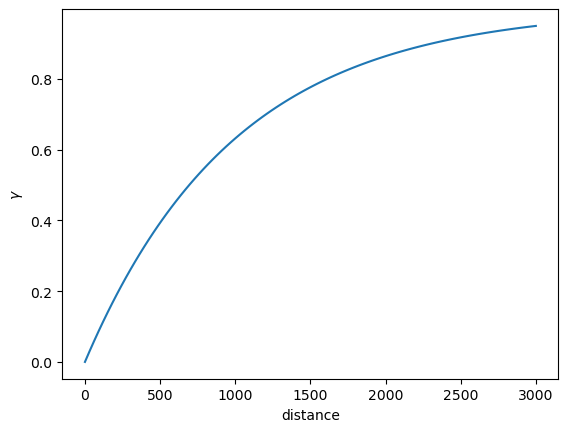

In [15]:
# exponential variogram for spatially varying parameters
v_grid = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=1000, # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
grid_gs = pyemu.geostats.GeoStruct(variograms=v_grid, transform='log') 

# plot the gs if you like:
ax = grid_gs.plot()

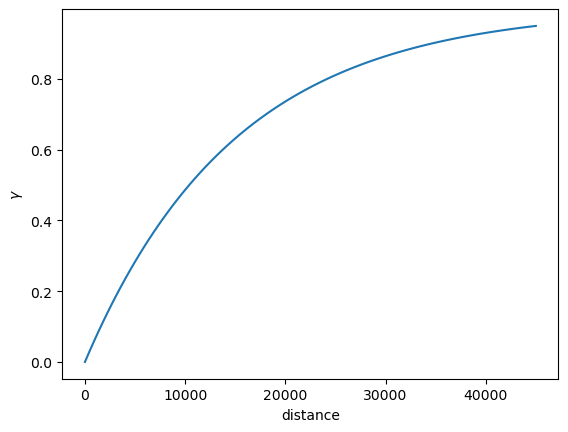

In [16]:
# exponential variogram for spatially varying parameters
v_pp = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=15000, # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
pp_gs = pyemu.geostats.GeoStruct(variograms=v_pp, transform='log') 

# plot the gs if you like:
_ = pp_gs.plot()

In [17]:
# exponential variogram for time varying parameters
v_time = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=60, # range of correlation; length time units (days)
                                    anisotropy=1.0, #do not change for 1-D time
                                    bearing=0.0 #do not change for 1-D time
                                    )

# geostatistical structure for time varying parameters
temporal_gs = pyemu.geostats.GeoStruct(variograms=v_time, transform='none') 

#### Add Parameters

Let's start by adding parameters of hydraulic properties that vary in space (but not time) and which are housed in array-type files (e.g. Kh, Kv, Ss, Sy). We will start by demonstrating step-by-step for Kh.

First, find all the external array files that contain Kh values. In our case, these are the files with "npf_k_" in the file name.

In [18]:
tag = "npf_k_"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.npf_k_layer1.txt']


Let's setup multiple spatial scales of parameters for Kh. To do this we will use three of the parameter "types" described above. The coarse scale will be a `constant` single value for each array. The medium scale will `pilot points`. The finest scale will use parameters as the `grid` scale (a unique parameter for each model cell!)

Each scale of parameters will work with the others as multipliers with the existing Kh arrays. (This all happens at runtime as part of the "model run" script.) Think of the scales as dials that PEST(++) can turn to improve the fit. The "coarse" scale is one big dial that allows PEST to move everything at once - that is, change the mean of the entire Kh array. The "medium" dials are few (but not too many) that allow PEST to adjust broad areas, but not making everything move. The "fine" scales are lots of small dials that allow PEST(++) to have very detailed control, tweaking parameter values within very small areas. 

However, because we are working with parameter `multipliers`, we will need to specify two sets of parameter bounds: 
 - `upper_bound` and `lower_bound` are the standard control file bounds (the bounds on the parameters that PEST sees), while
 - `ult_ubound` and `ult_lbound` are bounds that are applied at runtime to the resulting (multiplied out) model input array that MODFLOW reads. 
 
Since we are using sets of multipliers, it is important to make sure we keep the resulting model input arrays within the range of realistic values.

#### Array Files

We will first demonstrate step-by-step for `freyberg6.npf_k_layer1.txt`. We will start with grid scale parameters. These are multipliers assigned to each individual value in the array.

We start by getting the idomain array. As our model has inactive cells, this helps us avoid adding unnecessary parameters. It is also required later when generating pilot points.

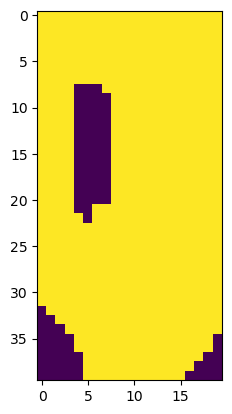

In [19]:
# get the IIDOMAIN array; in our case we only have one layer
ib = gwf.dis.idomain.array[0]
plt.imshow(ib)

In [20]:
f = 'freyberg6.npf_k_layer1.txt'

# grid (fine) scale parameters
df_gr = pf.add_parameters(f,
                zone_array=ib, #as we have inactive model cells, we can avoid assigning these as parameters
                par_type="grid", #specify the type, these will be unique parameters for each cell
                geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                par_name_base=f.split('.')[1].replace("_","")+"gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                pargp=f.split('.')[1].replace("_","")+"gr", #likewise for the parameter group name
                lower_bound=0.2, upper_bound=5.0, #parameter lower and upper bound
                ult_ubound=100, ult_lbound=0.01 # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                )

As when adding observations,  `pf.add_parameters()` returns a dataframe. Take a look. You may recognize a lot of the information that appears in a PEST `*parameter data` section. All of this is still only housed in memory for now. We will write the PEST control file later on.

(HUGE) Note: The `add_parameters()` call above added grid-scale parameters, that is, one parameter per active model cell for HK.  While this is fine for this simple demo problem, in practice, adding grid-scale parameters (while sexy!) can be a massive headache re storage, memory, computation, pre- and post-processing, etc, to the point that is can derail the entire modeling analysis.  So unless you are have really, really (REALLY!!!) good prediction-driven reason to use grid-scale parameters, we suggest using (denser) pilot points as a sweet-spot between grid-scale and zones to express reasonable and relevant hetereogeneity.  

In [21]:
df_gr.head()

,parnme,parval1,i,j,x,y,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,offset,scale,dercom,parchglim
pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,1.0,0,0,125.0,9875.0,npfklayer1gr,freyberg6_template\npfklayer1gr_inst0_grid.csv.tpl,freyberg6_template\mult\npfklayer1gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1.0,1,factor
pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,1.0,0,1,375.0,9875.0,npfklayer1gr,freyberg6_template\npfklayer1gr_inst0_grid.csv.tpl,freyberg6_template\mult\npfklayer1gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1.0,1,factor
pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,1.0,0,2,625.0,9875.0,npfklayer1gr,freyberg6_template\npfklayer1gr_inst0_grid.csv.tpl,freyberg6_template\mult\npfklayer1gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1.0,1,factor
pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,1.0,0,3,875.0,9875.0,npfklayer1gr,freyberg6_template\npfklayer1gr_inst0_grid.csv.tpl,freyberg6_template\mult\npfklayer1gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1.0,1,factor
pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,1.0,0,4,1125.0,9875.0,npfklayer1gr,freyberg6_template\npfklayer1gr_inst0_grid.csv.tpl,freyberg6_template\mult\npfklayer1gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1.0,1,factor


This `add_parameters()` call also wrote a template file that PEST(++) will use to populate the multiplier array at runtime:

In [22]:
[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

['npfklayer1gr_inst0_grid.csv.tpl']

Remember!  no PEST control file has been made yet. `PstFrom` is simply preparing to make a control file later...

Now, we add pilot point (medium scale) multiplier parameters to the same model input file. These multipliers are assigned to pilot points, which are subsequently interpolated to values in the array.

You can add pilot points in two ways:

1. `PstFrom` can generate them for you on a regular grid or 
2. you can supply `PstFrom` with existing pilot point location information in the form of a dataframe or a point-coverage shapefile. 

When you change `par_type` to "pilotpoints", by default, a regular grid of pilot points is set up using a default `pp_space` value of 10 (which is every 10th row and column). You can change this spacing by passing an integer to `pp_space` (as demonstrated below). 

Alternatively you can specify a filename or dataframe with pilot point locations. If you supply `pp_space` as a `str` it is assumed to be a filename. The extension is the guide: ".csv" for dataframe, ".shp" for shapefile (point-type). Anything else and the file is assumed to be a pilot points file type. The dataframe (or .csv file) must have "name", "x", and "y" as columns - it can have more, but must have those. 

In [23]:
# pilot point (medium) scale parameters
df_pp = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="pilotpoints",
                    geostruct=pp_gs,
                    par_name_base=f.split('.')[1].replace("_","")+"pp",
                    pargp=f.split('.')[1].replace("_","")+"pp",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01,
                    pp_space=5) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

starting interp point loop for 706 points
starting 0
starting 1
starting 2
starting 3
starting 4
starting 5
starting 6
starting 7
starting 8
starting 9
took 4.099295 seconds


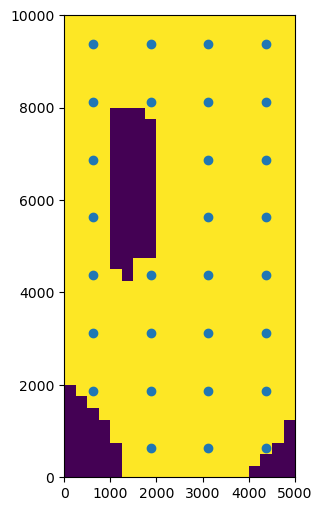

In [24]:
fig,ax = plt.subplots(1,1,figsize=(4,6))
ax.set_aspect("equal")
ax.pcolormesh(sr.xcentergrid, sr.ycentergrid,ib)
ax.scatter(df_pp.x,df_pp.y)

Lastly, add the constant (coarse) parameter multiplier. This is a single multiplier value applied to all values in the array. In practice, including a single constant parameter for each property can be an important parameter to include since it conceptually represents uncertainty in the mean property value

In [25]:
# constant (coarse) scale parameters
df_cst = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="constant",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1].replace("_","")+"cn",
                    pargp=f.split('.')[1].replace("_","")+"cn",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01)

Now we see three template files have been created:

In [26]:
[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

['npfklayer1cn_inst0_constant.csv.tpl',
 'npfklayer1gr_inst0_grid.csv.tpl',
 'npfklayer1pp_inst0pp.dat.tpl']

Feel free to navigate to the `template_ws` and inspect these files.

We are also going to visualize the HK array later (since everyone is crazy about HK in groundwater modeling).  To make this easier, we can also add the HK array as "observations" in the pest control file.  This isnt always a good idea, especially if your model has heaps of rows/columns/nodes (in which case, you have lots of other problems to worry about!), but for reasonably sized models, this is an easy way to access to the HK array that the model sees, especially in an ensemble framework where there are lots of parameter sets (and therefore lots of HK arrays).  `PstFrom` makes this easy...

In [27]:
df = pf.add_observations(f,prefix="hk",zone_array=ib)
df

,obsnme,obsval,weight,obgnme
oname:hk_otype:arr_i:0_j:0_zone:1,oname:hk_otype:arr_i:0_j:0_zone:1,11.1,1.0,hk
oname:hk_otype:arr_i:0_j:10_zone:1,oname:hk_otype:arr_i:0_j:10_zone:1,11.1,1.0,hk
oname:hk_otype:arr_i:0_j:11_zone:1,oname:hk_otype:arr_i:0_j:11_zone:1,11.1,1.0,hk
oname:hk_otype:arr_i:0_j:12_zone:1,oname:hk_otype:arr_i:0_j:12_zone:1,11.1,1.0,hk
oname:hk_otype:arr_i:0_j:13_zone:1,oname:hk_otype:arr_i:0_j:13_zone:1,11.1,1.0,hk
...,...,...,...,...
oname:hk_otype:arr_i:9_j:1_zone:1,oname:hk_otype:arr_i:9_j:1_zone:1,11.1,1.0,hk
oname:hk_otype:arr_i:9_j:2_zone:1,oname:hk_otype:arr_i:9_j:2_zone:1,11.1,1.0,hk
oname:hk_otype:arr_i:9_j:3_zone:1,oname:hk_otype:arr_i:9_j:3_zone:1,11.1,1.0,hk
oname:hk_otype:arr_i:9_j:8_zone:1,oname:hk_otype:arr_i:9_j:8_zone:1,11.1,1.0,hk


See those nice observation names with the "i" and "j" values baked in?

Now, back to parameterization...We are going to be repeating this multiplier-parameter scheme for each parameter type, so let's write a function.

In [28]:
def add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100, add_coarse=True):
    if isinstance(f,str):
        base = f.split(".")[1].replace("_","")
    else:
        base = f[0].split(".")[1]
    # grid (fine) scale parameters
    pf.add_parameters(f,
                    zone_array=ib,
                    par_type="grid", #specify the type, these will be unique parameters for each cell
                    geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                    par_name_base=base+"gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                    pargp=base+"gr", #likewise for the parameter group name
                    lower_bound=lb, upper_bound=ub, #parameter lower and upper bound
                    ult_ubound=uub, ult_lbound=ulb # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                    )
                    
    # pilot point (medium) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="pilotpoints",
                        geostruct=pp_gs,
                        par_name_base=base+"pp",
                        pargp=base+"pp",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb,
                        pp_space=5) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column
    if add_coarse==True:
        # constant (coarse) scale parameters
        pf.add_parameters(f,
                            zone_array=ib,
                            par_type="constant",
                            geostruct=grid_gs,
                            par_name_base=base+"cn",
                            pargp=base+"cn",
                            lower_bound=lb, upper_bound=ub,
                            ult_ubound=uub, ult_lbound=ulb)
    return

Let's speed through the other array parameter files.

In [29]:

# for Ss
tag = "sto_ss"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 2 and 3; we aren't monsters
for f in files[1:]: 
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=1e-7, uub=1e-3)

# For Sy
tag = "sto_sy"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 1
f = files[0]
add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=0.4)

# For porosity (particle tracking...)
tag = "ne_"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files: 
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=0.4)


In [30]:
len([f for f in os.listdir(template_ws) if f.endswith(".tpl")])

15

In [31]:
[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

['nelayer1cn_inst0_constant.csv.tpl',
 'nelayer1gr_inst0_grid.csv.tpl',
 'nelayer1pp_inst0pp.dat.tpl',
 'nelayer2cn_inst0_constant.csv.tpl',
 'nelayer2gr_inst0_grid.csv.tpl',
 'nelayer2pp_inst0pp.dat.tpl',
 'nelayer3cn_inst0_constant.csv.tpl',
 'nelayer3gr_inst0_grid.csv.tpl',
 'nelayer3pp_inst0pp.dat.tpl',
 'npfklayer1cn_inst0_constant.csv.tpl',
 'npfklayer1gr_inst0_grid.csv.tpl',
 'npfklayer1pp_inst0pp.dat.tpl',
 'stosylayer1cn_inst0_constant.csv.tpl',
 'stosylayer1gr_inst0_grid.csv.tpl',
 'stosylayer1pp_inst0pp.dat.tpl']

Boom!  We just conquered property parameterization in a big way!

#### Spatial and Temporal Correlation

Now, you may be thinking "shouldn't recharge have temporal correlation as well?". 

Damn straight it should. Now, this requires a little trickery because native handling in spatiotemporal correlation is hard to do.  So what we are going to do is split this correlation into two setup of multiplier parameters.  One set of parameters will be constant in space but vary (and be correlated) in time.  The other set of multiplier parameters will be constant in time but vary (and be correlated) in space.  Since both of these sets of parameters are multipliers, we implicitly represent the concept that recharge is uncertain and correlated in both space and time.  Easy as!

First we need to construct a container of stress period datetimes. (This relies on specifying the start_datetime argument when instantiating `PstFrom`.) These datetime values will specify the position of parameters on the time-axis.



In [32]:
# build up a container of stress period start datetimes - this will
# be used to specify the datetime of each multipler parameter

dts = pd.to_datetime(start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d')

dts

DatetimeIndex(['2017-12-31 12:00:00', '2018-01-31 12:00:00',
               '2018-03-01 12:00:00', '2018-04-01 12:00:00',
               '2018-05-01 12:00:00', '2018-06-01 12:00:00',
               '2018-07-01 12:00:00', '2018-08-01 12:00:00',
               '2018-09-01 12:00:00', '2018-10-01 12:00:00',
               '2018-11-01 12:00:00', '2018-12-01 12:00:00',
               '2019-01-01 12:00:00', '2019-02-01 12:00:00',
               '2019-03-01 12:00:00', '2019-04-01 12:00:00',
               '2019-05-01 12:00:00', '2019-06-01 12:00:00',
               '2019-07-01 12:00:00', '2019-08-01 12:00:00',
               '2019-09-01 12:00:00', '2019-10-01 12:00:00',
               '2019-11-01 12:00:00', '2019-12-01 12:00:00',
               '2020-01-01 12:00:00'],
              dtype='datetime64[ns]', freq=None)

If you use the same parameter group name (`pargp`) and same geostruct, `PstFrom` will treat parameters setup across different calls to `add_parameters()` as correlated - ***WARNING*** do not try to express spatial and temporal correlation together - as discussed above, #badtimes.  In this case, we want to express temporal correlation in the recharge multiplier parameters that are "constant" type in space so that there is one recharge multiplier parameter for each stress period that shares a parameter group name across different calls to `add_parameters`. So, we use the same parameter group names for each stress period data file, and specify the `datetime` and `geostruct` arguments.

Including temporal correlation introduces an additional challenge. Interpolation between points that share a common coordinate creates all types of trouble. We are going to have many parameters during each stress period (a single point on the time-axis). To get around this challenge we need to be a bit sneaky.


First, we will apply the multiple *spatial* scales of parameter multipliers (`constant`, `pilot point` and `grid`) as we did for hydraulic properties.  We do this for all recharge files at once, which tells `PstFrom` to broadcast (e.g. share) the same parameters for all of those files: 



In [33]:
# for Recharge; 
tag = "rch_recharge"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
sp = [int(f.split(".")[1].split('_')[-1]) for f in files]
d = {s:f for s,f in zip(sp,files)}
sp.sort()
files = [d[s] for s in sp]
print(files)
# the spatial multiplier parameters; just use the same function
add_mult_pars(files, lb=0.2, ub=5.0, ulb=0, uub=1e-3, add_coarse=False)

['freyberg6.rch_recharge_1.txt', 'freyberg6.rch_recharge_2.txt', 'freyberg6.rch_recharge_3.txt', 'freyberg6.rch_recharge_4.txt', 'freyberg6.rch_recharge_5.txt', 'freyberg6.rch_recharge_6.txt', 'freyberg6.rch_recharge_7.txt', 'freyberg6.rch_recharge_8.txt', 'freyberg6.rch_recharge_9.txt', 'freyberg6.rch_recharge_10.txt', 'freyberg6.rch_recharge_11.txt', 'freyberg6.rch_recharge_12.txt', 'freyberg6.rch_recharge_13.txt', 'freyberg6.rch_recharge_14.txt', 'freyberg6.rch_recharge_15.txt', 'freyberg6.rch_recharge_16.txt', 'freyberg6.rch_recharge_17.txt', 'freyberg6.rch_recharge_18.txt', 'freyberg6.rch_recharge_19.txt', 'freyberg6.rch_recharge_20.txt', 'freyberg6.rch_recharge_21.txt', 'freyberg6.rch_recharge_22.txt', 'freyberg6.rch_recharge_23.txt', 'freyberg6.rch_recharge_24.txt', 'freyberg6.rch_recharge_25.txt']


In [34]:
len([f for f in os.listdir(template_ws) if f.endswith(".tpl")])

17

Then, we will assign an additional `constant` multiplier parameter for each recharge stress-period file (so, a single multiplier for all recharge parameters for each stress period). We will specify temporal correlation for these `constant` multipliers. These will all have the same parameter group name, as discussed above. 

In [35]:
for f in files:   
    # multiplier that includes temporal correlation
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                    zone_array=ib,
                    par_type="constant",
                    par_name_base=f.split('.')[1]+"tcn",
                    pargp=f.split('.')[1]+"tcn",
                    lower_bound=0.5, upper_bound=1.5,
                    ult_ubound=1e-3, ult_lbound=0,
                    datetime=dts[kper], # this places the parameter value on the "time axis"
                    geostruct=temporal_gs)

Sweet! Done!

### List Files

Adding parameters from list-type files follows similar principles. As with observation files, they must be tabular. Certain columns are specified as index columns and are used to populate parameter names, as well as provide the parameters' spatial location. Other columns are specified as containing parameter values. 

Parameters can be `grid` or `constant`. As before, values can be assigned `directly`, as `multipliers` or as `additives`.

We will demonstrate for the boundary-condition input files. 

Starting off with GHBs. Let's inspect the folder. As you can see, there is a single input file (here we assume GHB parameters do not vary over time).

In [36]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.ghb_stress_period_data_1.txt']


Since these boundaries are likely to be very influential, we want to include a robust representation of their uncertainty - both head and conductance and at multiple scales.  

Let's parameterize both GHB conductance and head:

 - For conductance, we shall use two scales of `multiplier` parameters (`constant` and `grid`).

 - For heads, multipliers are not ideal. Instead we will use `additive` parameters. Again, with a coarse and fine scale.

 **ATTENTION!** 
 
 Additive parameters by default get assigned an initial parameter value of zero. This can be problematic later on when computing the derivatives. Be sure to either apply a parameter offset, or use "absolute" increment types in the parameter group section (we will implement the latter option further on in the current tutorial.)

In [37]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]

for f in files:
    # constant and grid scale multiplier conductance parameters
    name = 'ghbcond'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"gr",
                        pargp=name+"gr",
                        index_cols=[0,1,2], #column containing lay,row,col
                        use_cols=[4], #column containing conductance values
                        lower_bound=0.1,upper_bound=10.0)
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"cn",
                        pargp=name+"cn",
                        index_cols=[0,1,2],
                        use_cols=[4],  
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.01, ult_ubound=100) #absolute limits

    # constant and grid scale additive head parameters
    name = 'ghbhead'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"gr",
                        pargp=name+"gr",
                        index_cols=[0,1,2],
                        use_cols=[3],   # column containing head values
                        lower_bound=-2.0,upper_bound=2.0,
                        par_style="a", # specify additive parameter
                        transform="none", # specify not log-transform
                        ult_lbound=32.5, ult_ubound=42) #absolute limits; make sure head is never lower than the bottom of layer1
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"cn",
                        pargp=name+"cn",
                        index_cols=[0,1,2],
                        use_cols=[3],
                        lower_bound=-2.0,upper_bound=2.0, 
                        par_style="a", 
                        transform="none",
                        ult_lbound=32.5, ult_ubound=42) 

Easy peasy.

Now, this will make some people uncomfortable, but how well do we really ever know historic water use flux rates in space and in time? hmmm, not really! And just a little uncertainty in historic water use can result in large changes in simulated water levels...So let's add parameters to represent that uncertainty in the model inputs.

For wells it may not (or it may...) make sense to include spatial correlation. Here we will assume temporal correlation - its reasonable that pumping rates today will be similar to pumping rates yesterday. 

Pumping rates for different stress periods are in separate files. We will call `.add_parameters()` for each file. But we want to specify correlation between parameters in different files. As explained above for recharge, we do this with the parameter group name.

OK, let's get started.


As discussed above, including temporal correlation introduces an additional challenge. We use the same approach described for recharge parameters:

 - First, we will assign a `constant` multiplier parameter for each WEL stress-period file (so, a single multiplier for all well pumping rates for each stress period). We will specify temporal correlation for these `constant` multipliers.

 - Then, we will also have `grid` type multiplier parameters for each WEL stress period file (so, multipliers for individual well pumping rate during each stress period). These will not include (temporal) correlation. (We could in principle include spatial correlation here if we wanted to; but let's not).

In [38]:
files = [f for f in os.listdir(template_ws) if "wel_stress_period_data" in f and f.endswith(".txt")]
sp = [int(f.split(".")[1].split('_')[-1]) for f in files]
d = {s:f for s,f in zip(sp,files)}
sp.sort()
files = [d[s] for s in sp]

for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location
                        use_cols=[3],       #columns with parameter values
                        par_type="constant",    #each well will be adjustable
                        par_name_base="welcst",
                        pargp="welcst", 
                        upper_bound = 4, lower_bound=0.25,
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)
    
    # add the grid parameters; each individual well
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location 
                        use_cols=[3],       #columns with parameter values
                        par_type="grid",    #each well will be adjustable
                        par_name_base="welgrd",
                        pargp="welgrd", 
                        upper_bound = 4, lower_bound=0.25,
                        datetime=dts[kper]) # this places the parameter value on the "time axis"
                     

And finally, our favorite (not!) boundary-condition: SFR.

Let's parameterize conductance (time-invariant) and inflow (time-variant).

In [39]:
# SFR conductance
tag = "sfr_packagedata"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
assert len(files) == 1 # There can be only one! It is tradition. Jokes.
print(files)

f = files[0]
# constant and grid scale multiplier conductance parameters
name = "sfrcond"
pf.add_parameters(f,
                par_type="grid",
                geostruct=grid_gs,
                par_name_base=name+"gr",
                pargp=name+"gr",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0)
pf.add_parameters(f,
                par_type="constant",
                geostruct=grid_gs,
                par_name_base=name+"cn",
                pargp=name+"cn",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.001, ult_ubound=100) #absolute limits

['freyberg6.sfr_packagedata.txt']


,parnme,pargp,covgp,tpl_filename,input_filename,parval1,partype,partrans,parubnd,parlbnd,offset,scale,dercom,parchglim
pname:sfrcondcn_inst:0_ptype:cn_usecol:9_pstyle:m,pname:sfrcondcn_inst:0_ptype:cn_usecol:9_pstyle:m,sfrcondcn,sfrcondcn,freyberg6_template\sfrcondcn_inst0_constant.csv.tpl,freyberg6_template\mult\sfrcondcn_inst0_constant.csv,1.0,constant,log,10.0,0.1,0.0,1.0,1,factor


In [40]:
# SFR inflow
files = [f for f in os.listdir(template_ws) if "sfr_perioddata" in f and f.endswith(".txt")]
sp = [int(f.split(".")[1].split('_')[-1]) for f in files]
d = {s:f for s,f in zip(sp,files)}
sp.sort()
files = [d[s] for s in sp]
print(files)
for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    # add the parameters
    pf.add_parameters(filenames=f,
                        index_cols=[0], #reach number
                        use_cols=[2],   #columns with parameter values
                        par_type="grid",    
                        par_name_base="sfrgr",
                        pargp="sfrgr", 
                        upper_bound = 10, lower_bound=0.1, #don't need ult_bounds because it is a single multiplier
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)

['freyberg6.sfr_perioddata_1.txt']


In [41]:
[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

['ghbcondcn_inst0_constant.csv.tpl',
 'ghbcondgr_inst0_grid.csv.tpl',
 'ghbheadcn_inst0_constant.csv.tpl',
 'ghbheadgr_inst0_grid.csv.tpl',
 'nelayer1cn_inst0_constant.csv.tpl',
 'nelayer1gr_inst0_grid.csv.tpl',
 'nelayer1pp_inst0pp.dat.tpl',
 'nelayer2cn_inst0_constant.csv.tpl',
 'nelayer2gr_inst0_grid.csv.tpl',
 'nelayer2pp_inst0pp.dat.tpl',
 'nelayer3cn_inst0_constant.csv.tpl',
 'nelayer3gr_inst0_grid.csv.tpl',
 'nelayer3pp_inst0pp.dat.tpl',
 'npfklayer1cn_inst0_constant.csv.tpl',
 'npfklayer1gr_inst0_grid.csv.tpl',
 'npfklayer1pp_inst0pp.dat.tpl',
 'rch_recharge_10tcn_inst0_constant.csv.tpl',
 'rch_recharge_11tcn_inst0_constant.csv.tpl',
 'rch_recharge_12tcn_inst0_constant.csv.tpl',
 'rch_recharge_13tcn_inst0_constant.csv.tpl',
 'rch_recharge_14tcn_inst0_constant.csv.tpl',
 'rch_recharge_15tcn_inst0_constant.csv.tpl',
 'rch_recharge_16tcn_inst0_constant.csv.tpl',
 'rch_recharge_17tcn_inst0_constant.csv.tpl',
 'rch_recharge_18tcn_inst0_constant.csv.tpl',
 'rch_recharge_19tcn_inst0_c

Damn!  we just parameterized many recognized sources of model input uncertainty at several spatial and temporal scales.  And we expressed spatial and temporal correlation in those parameters.  One last set of parameters that we will need later for sequential data assimilation - initial conditions:

In [42]:
files = [f for f in os.listdir(template_ws) if "ic_strt" in f and f.endswith(".txt")]
files

['freyberg6.ic_strt_layer1.txt']

In [43]:
for f in files:
    base = f.split(".")[1].replace("_","")
    df = pf.add_parameters(f,par_type="grid",par_style="d",
                      pargp=base,par_name_base=base,upper_bound=50,
                     lower_bound=15,zone_array=ib,transform="none")
    print(df.shape)

(706, 17)


### The Forward Run Script

OK! So, we almost have all the base building blocks for a PEST(++) dataset. We have some (1) observations and some (2) parameters. We are still missing (3) the "forward run" script. Recall that in the PEST world, the "model" is not just the numerical model (e.g. MODFLOW). Instead it is a composite of the numerical model (or models) and pre- and post-processing steps, encapsulated in a "forward run" script which can be called from the command line. This command line instruction is what PEST(++) sees as "the model". During execution, PEST(++) writes values to parameter files, runs "the model", and then reads values from the observation files.

`PstFrom` automates the generation of such a script when constructing the PEST control file. The script is written to file named `forward_run.py`. It is written in Python (this is not a PEST(++) requirement, merely a convenience...we are working in Python after all...). 

How about we see that in action? Magic time! Let's create the PEST control file.

In [44]:
pst = pf.build_pst()

noptmax:0, npar_adj:5410, nnz_obs:1106


Boom! Done. (Well almost.) Check the folder. You should see a new .pst file and the `forward_run.py` file. By default, the .pst file is named after the original model folder name. 

In [45]:
[f for f in os.listdir(template_ws) if f.endswith(".py") or f.endswith(".pst") ]

['forward_run.py', 'freyberg_mf6.pst']

We will get to the `pst` object later on (see also the "intro to pyemu" tutorial notebook). For now, let's focus on the `forward_run.py` script. It is printed out below.

This script does a bunch of things:
 - it loads necessary dependencies
 - it removes model output files to avoid the possibility of files from a previous model run being read by mistake;
 - it runs pre-processing steps (see `pyemu.helpers.apply_list_and_array_pars()`;
 - it executes system commands (usually running the simulator, i.e. MODFLOW). (*This is still missing. We will demonstrate next.*)
 - it executes post-processing steps; (*for now there aren't any*)
 - ...it washes the dishes (sorry, no it doesn't...this feature is still in development).

In [46]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    try:
       os.remove(r'freyberg6.npf_k_layer1.txt')
    except Exception as e:
       print(r'error removing tmp file:freyberg6.npf_k_layer1.txt')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)

if __name__ == '__main__':
    mp.freeze_support()
    main()



That's pretty amazing. But as we just saw, we still need to add commands to actually run the model.

`PstFrom` allows you to pass a list of system commands which will be executed in sequence. It also has methods for including Python functions that run before or after the system commands. These make pre-/post-processing a piece of cake. In fact, we have already started to add to it. Remember all of the multiplier and additive parameters we setup? These all require pre-processing steps to convert the PEST-generated multipliers into model input values. `PstFrom` will automatically add these functions to the `forward_run.py` script. Nifty, hey?

Next we will demonstrate how to specify the system commands and add Python functions as processing steps.

#### Sys Commands

Let's start by adding a command line instruction. These are stored as a list in `PstFrom.mod_sys_cmds`, which is currently empty. 

In [47]:
pf.mod_sys_cmds 

[]

To run a MODFLOW6 model from the command line, you can simply execute `mf6` in the model folder. So, we can add this command by appending it to the list. (Do this only once! Every time you append 'mf6' results in an additional call to MODFLOW6, meaning the model would be run multiple times.)

`PstFrom` will add a line to `forward_run.py` w

In [48]:
pf.mod_sys_cmds.append("mf6") #do this only once
pf.mod_sys_cmds

['mf6']

We also need to run MODPATH7, so we need to add that to the list of system commands. In this case we also need to specify the modpath sim file:

In [49]:
pf.mod_sys_cmds.append("mp7 freyberg_mp.mpsim") #do this only once
pf.mod_sys_cmds

['mf6', 'mp7 freyberg_mp.mpsim']

OK, now let's re-build the Pst control file and check out the changes to the `forward_run.py` script.

You should see that `pyemu.os_utils.run(r'mf6')` has been added after the pre-processing functions.

In [50]:
pst = pf.build_pst()

_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

noptmax:0, npar_adj:5410, nnz_obs:1106
import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    try:
       os.remove(r'freyberg6.npf_k_layer1.txt')
    except Exception as e:
       print(r'error removing tmp file:freyberg6.npf_k_layer1.txt')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)
    pyemu.os_utils.run(r'mf6')

    pyemu.os_utils.run(r'mp7 freyberg_mp.mpsim')


if __name__ == '__main__':
    mp.freeze_support()
    main()



#### Extra pre- and post-processing functions

You will also certainly need to include some additional processing steps.  These are supported through the `PstFrom.pre_py_cmds` and `PstFrom.post_py_cmds`, which are lists for pre and post model run python commands and `PstFrom.pre_sys_cmds` and `PstFrom.post_sys_cmds`, which are lists for pre and post model run system commands (these are wrapped in `pyemu.os_utils.run()`.  

But what if your additional steps are actually an entire python function? Well, we got that too! `PstFrom.add_py_function()`. This method allows you to get functions from another (pre-prepared) python source file and add them to the `forward_run.py` script. We will demonstrate this to post-process model observations after each run.

Now let's see this py-sauce in action: we are going to add a little post-processing function to extract the final simulated water level for all model cells for the last stress period from the MF6 binary headsave file and save them to ASCII format so that PEST(++) can read them with instruction files.  And, while we are at it, let's also extract the global water budget info from the MF6 listing file and store it in dataframes - these are usually good numbers to watch!  We will need the simulated water level arrays later for sequential data assimilation (wouldn't it be nice if MF6 supported the writing of ASCII format head arrays?).  Anyway, this function is stored in the "helpers.py" script which you can find in the tutorial folder.

In [51]:
pf.add_py_function("helpers.py","extract_hds_arrays_and_list_dfs()",is_pre_cmd=False)

That last argument - `is_pre_cmd` tells `PstFrom` if the python function should be treated as a pre-processor or a post-processor. So we have added that post-processor, but we still need to setup pest observations for those ASCII head arrays.  Let's do that by first calling that function to operate once within the `template_ws` to generate the arrays and then we can add them with `add_observations()`:  

In [52]:
import helpers
helpers.test_extract_hds_arrays(template_ws)

In [53]:
files = [f for f in os.listdir(template_ws) if f.startswith("hdslay")]
files

['hdslay1_t1.txt',
 'hdslay1_t10.txt',
 'hdslay1_t11.txt',
 'hdslay1_t12.txt',
 'hdslay1_t13.txt',
 'hdslay1_t14.txt',
 'hdslay1_t15.txt',
 'hdslay1_t16.txt',
 'hdslay1_t17.txt',
 'hdslay1_t18.txt',
 'hdslay1_t19.txt',
 'hdslay1_t2.txt',
 'hdslay1_t20.txt',
 'hdslay1_t21.txt',
 'hdslay1_t22.txt',
 'hdslay1_t23.txt',
 'hdslay1_t24.txt',
 'hdslay1_t25.txt',
 'hdslay1_t3.txt',
 'hdslay1_t4.txt',
 'hdslay1_t5.txt',
 'hdslay1_t6.txt',
 'hdslay1_t7.txt',
 'hdslay1_t8.txt',
 'hdslay1_t9.txt']

In [54]:
for f in files:
    pf.add_observations(f,prefix=f.split(".")[0],obsgp=f.split(".")[0])

In [55]:
for f in ["inc.csv","cum.csv"]:
    df = pd.read_csv(os.path.join(template_ws,f),index_col=0)
    pf.add_observations(f,index_cols=["totim"],use_cols=list(df.columns.values),
                        prefix=f.split('.')[0],obsgp=f.split(".")[0])

Crushed it!

#### Secondary Observations

Often it is usefull to include "secondary model outcomes" as observations. These can be important components in a history-matching dataset to tease out specific aspects of system behaviour (e.g. head differences between aquifer layers to inform vertical permeabilities). Or they may be simple summaries of modelled outputs which are of interest for a prediction (e.g. minimum simulated head over a given period).

If you inspect the tutorial folder you will find a file named `helpers.py`. This is a python source file which we have prepared for you. (Open it to see how it is organized.) This is not standard `pyemu` functionality, but we provide it here as an example of incorporating custom code for observation processing. The sky's the limit! It contains a function named `process_secondary_obs()`. This function reads the model output .csv files, processes them and writes a series of new observation .csv files. These new files contain the temporal-differences between head and SFR observations. The new .csv files are named `heads.tdiff.csv`and `sfr.tdiff.csv`, respectively.

First, let's load the function here and run it so you can see what happens. (And to make sure that the observation files are in the template folder!) 

Run the next cell, then inspect the template folder. You should see several new csv files. These are the new secondary observations calculated by the post-processing function.

In [56]:
# run the helper function
helpers.process_secondary_obs(ws=template_ws)

Secondary observation files processed.


In [57]:
[f for f in os.listdir(template_ws) if f.endswith(".csv")]

['cum.csv',
 'heads.csv',
 'heads.tdiff.csv',
 'inc.csv',
 'mult2model_info.csv',
 'sfr.csv',
 'sfr.tdiff.csv']

OK, so now let's add this function to the `forward_run.py` script.

In [58]:
pf.add_py_function("helpers.py", # the file which contains the function
                    "process_secondary_obs(ws='.')", #the function, making sure to specify any arguments it may requrie
                    is_pre_cmd=False) # whether it runs before the model system command, or after. In this case, after.

And, boom! Bob's your uncle. As easy as that.

Now, of course we want to add these observations to `PstFrom` as well:

In [59]:

df = pd.read_csv(os.path.join(template_ws, "sfr.tdiff.csv"), index_col=0)
_ = pf.add_observations("sfr.tdiff.csv", # the model output file to read
                            insfile="sfr.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfrtd") #prefix to all observation 
                            
df = pd.read_csv(os.path.join(template_ws, "heads.tdiff.csv"), index_col=0)
_ = pf.add_observations("heads.tdiff.csv", # the model output file to read
                            insfile="heads.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdstd") #prefix to all observation names

Remember to re-build the Pst control file:

In [60]:
pst = pf.build_pst()

noptmax:0, npar_adj:5410, nnz_obs:21956


In [61]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu

# function added thru PstFrom.add_py_function()
def extract_hds_arrays_and_list_dfs():
    import flopy
    hds = flopy.utils.HeadFile("freyberg6_freyberg.hds")
    for it,t in enumerate(hds.get_times()):
        d = hds.get_data(totim=t)
        for k,dlay in enumerate(d):
            np.savetxt("hdslay{0}_t{1}.txt".format(k+1,it+1),d[k,:,:],fmt="%15.6E")

    lst = flopy.utils.Mf6ListBudget("freyberg6.lst")
    inc,cum = lst.get_dataframes(diff=True,start_datetime=None)
    inc.columns = inc.columns.map(lambda x: x.lower().replace("_","-"))
    cum.columns = cum.columns.map(lambda x: x.lower().replace("_", "-"))
    inc.index.name = "totim"
    cum.index.name = "totim"
    inc.to_csv("inc.csv")
    cum.to_csv("cum.csv")
    return




# function added thru PstFrom.add_py_function()
def process_secondary_obs(ws='.'):
    # load dependencies insde the function so that they get carried over to fo

Now we see that `extract_hds_array_and_list_dfs()` has been added to the forward run script and it is being called after MF6 runs. 

In [62]:
obs = pst.observation_data
obs

,obsnme,obsval,weight,obgnme,i,j,oname,otype,time,totim,usecol,zone
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3652.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3652.5,34.797358,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10,NaN,NaN,hds,lst,3652.5,NaN,trgw-0-13-10,NaN
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3683.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3683.5,34.768494,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10,NaN,NaN,hds,lst,3683.5,NaN,trgw-0-13-10,NaN
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3712.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3712.5,34.821230,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10,NaN,NaN,hds,lst,3712.5,NaN,trgw-0-13-10,NaN
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3743.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3743.5,34.920983,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10,NaN,NaN,hds,lst,3743.5,NaN,trgw-0-13-10,NaN
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3773.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3773.5,35.008383,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10,NaN,NaN,hds,lst,3773.5,NaN,trgw-0-13-10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
oname:hdstd_otype:lst_usecol:trgw-0-9-1_time:4261.5,oname:hdstd_otype:lst_usecol:trgw-0-9-1_time:4261.5,-0.416852,1.0,oname:hdstd_otype:lst_usecol:trgw-0-9-1,NaN,NaN,hdstd,lst,4261.5,NaN,trgw-0-9-1,NaN
oname:hdstd_otype:lst_usecol:trgw-0-9-1_time:4291.5,oname:hdstd_otype:lst_usecol:trgw-0-9-1_time:4291.5,-0.669533,1.0,oname:hdstd_otype:lst_usecol:trgw-0-9-1,NaN,NaN,hdstd,lst,4291.5,NaN,trgw-0-9-1,NaN
oname:hdstd_otype:lst_usecol:trgw-0-9-1_time:4322.5,oname:hdstd_otype:lst_usecol:trgw-0-9-1_time:4322.5,-0.927476,1.0,oname:hdstd_otype:lst_usecol:trgw-0-9-1,NaN,NaN,hdstd,lst,4322.5,NaN,trgw-0-9-1,NaN
oname:hdstd_otype:lst_usecol:trgw-0-9-1_time:4352.5,oname:hdstd_otype:lst_usecol:trgw-0-9-1_time:4352.5,-1.116548,1.0,oname:hdstd_otype:lst_usecol:trgw-0-9-1,NaN,NaN,hdstd,lst,4352.5,NaN,trgw-0-9-1,NaN


### After Building the Control File

At this point, we can do some additional modifications that would typically be done that are problem specific.  Here we can tweak the setup, specifying things such as observation weights, parameter bounds, transforms, control data, etc.

Note that any modifications made after calling `PstFrom.build_pst()` will only exist in memory - you need to call `pf.pst.write()` to record these changes to the control file on disk.  Also note that if you call `PstFrom.build_pst()` after making some changes, these changes will be lost.  

For the current case, the main thing we haven't addressed are the observations from custom *.ins files,  observation weights, parameter group INCTYP's and forecasts.

We will do so now.

#### Add Observations from INS files

Recall that we wish to include observations of particle end time and status. As mentioned earlier, MP7 output files are not ina nicely organized tabular format - so we need to construct a custom instruction file. We will do this now:

In [63]:
# write a really simple instruction file to read the MODPATH end point file
out_file = "freyberg_mp.mpend"
ins_file = out_file + ".ins"
with open(os.path.join(template_ws, ins_file),'w') as f:
    f.write("pif ~\n")
    f.write("l7 w w w w !part_status! w w !part_time!\n")

Now add these observations to the `Pst`:

In [64]:
pst.add_observations(ins_file=os.path.join(template_ws, ins_file),
                    out_file=os.path.join(template_ws, out_file),
                            pst_path='.')

# and then check what changed                            
obs = pst.observation_data
obs.loc[obs.obsnme=='part_status', 'obgnme'] = 'part'
obs.loc[obs.obsnme=='part_time', 'obgnme'] = 'part'

obs.iloc[-2:]

2 obs added from instruction file freyberg6_template\.\freyberg_mp.mpend.ins


,obsnme,obsval,weight,obgnme,i,j,oname,otype,time,totim,usecol,zone
part_status,part_status,5.00000,1.0,part,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
part_time,part_time,99358.42916,1.0,part,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Parameters with Zero as Intial Value

Recall that we assigned additive parameters to the GHB heads. Our initial parameter values for these parameter types were set as 0 (zero). This creates a wee bit of trouble when calculating derivatives - this is only an issue for algorithms that use finite-difference derivatives. There are a couple of ways we could get around it. One way is to add an "offset" to the parameter initial values and to the parameter bounds. Another is to use "absolute" increment types (INCTYP). See the PEST manual or PEST++ user guides for descriptions of increment types. 

We will apply both here. 

We will assign INCTYP as 'absolute'. We will leave DERINC as 0.01 (the default). It is a reasonable value in this case.

In [65]:
head_pargps = [i for i in pst.adj_par_groups if 'head' in i]
head_pargps

['ghbheadgr', 'ghbheadcn']

In [66]:
pst.parameter_groups.loc[head_pargps, 'inctyp'] = 'absolute'

Now add the "offset" to parameter data entries:

In [67]:
par = pst.parameter_data
par_names = par.loc[par.parval1==0].parnme

par.loc[par_names].head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,i,idx0,idx1,idx2,inst,j,pname,pstyle,ptype,usecol,x,y,zone
pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:5,pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:5,none,relative,0.0,-2.0,2.0,ghbheadgr,1.0,0.0,1,NaN,0,39,5,0,NaN,ghbheadgr,a,gr,3,NaN,NaN,NaN
pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:6,pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:6,none,relative,0.0,-2.0,2.0,ghbheadgr,1.0,0.0,1,NaN,0,39,6,0,NaN,ghbheadgr,a,gr,3,NaN,NaN,NaN
pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:7,pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:7,none,relative,0.0,-2.0,2.0,ghbheadgr,1.0,0.0,1,NaN,0,39,7,0,NaN,ghbheadgr,a,gr,3,NaN,NaN,NaN
pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:8,pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:8,none,relative,0.0,-2.0,2.0,ghbheadgr,1.0,0.0,1,NaN,0,39,8,0,NaN,ghbheadgr,a,gr,3,NaN,NaN,NaN
pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:9,pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:9,none,relative,0.0,-2.0,2.0,ghbheadgr,1.0,0.0,1,NaN,0,39,9,0,NaN,ghbheadgr,a,gr,3,NaN,NaN,NaN


In [68]:
offset = -10
par.loc[par_names, 'offset'] = offset
par.loc[par_names, ['parval1', 'parlbnd', 'parubnd']] -= offset

par.loc[par_names].head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,i,idx0,idx1,idx2,inst,j,pname,pstyle,ptype,usecol,x,y,zone
pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:5,pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:5,none,relative,10.0,8.0,12.0,ghbheadgr,1.0,-10.0,1,NaN,0,39,5,0,NaN,ghbheadgr,a,gr,3,NaN,NaN,NaN
pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:6,pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:6,none,relative,10.0,8.0,12.0,ghbheadgr,1.0,-10.0,1,NaN,0,39,6,0,NaN,ghbheadgr,a,gr,3,NaN,NaN,NaN
pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:7,pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:7,none,relative,10.0,8.0,12.0,ghbheadgr,1.0,-10.0,1,NaN,0,39,7,0,NaN,ghbheadgr,a,gr,3,NaN,NaN,NaN
pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:8,pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:8,none,relative,10.0,8.0,12.0,ghbheadgr,1.0,-10.0,1,NaN,0,39,8,0,NaN,ghbheadgr,a,gr,3,NaN,NaN,NaN
pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:9,pname:ghbheadgr_inst:0_ptype:gr_usecol:3_pstyle:a_idx0:0_idx1:39_idx2:9,none,relative,10.0,8.0,12.0,ghbheadgr,1.0,-10.0,1,NaN,0,39,9,0,NaN,ghbheadgr,a,gr,3,NaN,NaN,NaN


#### Forecasts

For most models there is a forecast/prediction that someone needs. Rather than waiting until the end of the project, the forecast should be entered into your thinking and workflow __right at the beginning__.  Here we do this explicitly by monitoring the forecasts as "observations" in the control file.  This way, for every PEST(++) analysis we do, we can watch what is happening to the forecasts - #winning

The optional PEST++ `++forecasts` control variable allows us to provide the names of one or more observations featured in the "observation data" section of the PEST control file; these are treated as predictions in FOSM predictive uncertainty analysis by PESTPP-GLM. It is also a convenient way to keep track of "forecast" observations (makes post-processing a wee bit easier later on).

Recall that, for our synthetic case we are interested in forecasting:

 - groundwater level in the upper layer at row 9 and column 1 (site named "trgw-0-9-1") in stress period 22 (time=640);
 - the "tailwater" surface-water/groundwater exchange during stress period 13 (time=367); and
 - the "headwater" surface-water/groundwater exchange at stress period 22 (time=640).
 - the particle travel time.


In [69]:
forecasts =[
            'oname:sfr_otype:lst_usecol:tailwater_time:4383.5',
            'oname:sfr_otype:lst_usecol:headwater_time:4383.5',
            'oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5',
            'part_time'
            ]

forecasts

['oname:sfr_otype:lst_usecol:tailwater_time:4383.5',
 'oname:sfr_otype:lst_usecol:headwater_time:4383.5',
 'oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5',
 'part_time']

In [70]:
fobs = obs.loc[forecasts,:]
fobs

,obsnme,obsval,weight,obgnme,i,j,oname,otype,time,totim,usecol,zone
oname:sfr_otype:lst_usecol:tailwater_time:4383.5,oname:sfr_otype:lst_usecol:tailwater_time:4383.5,92.911368,1.0,oname:sfr_otype:lst_usecol:tailwater,NaN,NaN,sfr,lst,4383.5,NaN,tailwater,NaN
oname:sfr_otype:lst_usecol:headwater_time:4383.5,oname:sfr_otype:lst_usecol:headwater_time:4383.5,-127.192506,1.0,oname:sfr_otype:lst_usecol:headwater,NaN,NaN,sfr,lst,4383.5,NaN,headwater,NaN
oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,35.559841,1.0,oname:hds_otype:lst_usecol:trgw-0-9-1,NaN,NaN,hds,lst,4383.5,NaN,trgw-0-9-1,NaN
part_time,part_time,99358.429160,1.0,part,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will just set this optional pest++ argument because it will trigger certain automatic behavior later in PESTPP-GLM

In [71]:
pst.pestpp_options['forecasts'] = forecasts

### Re-write the Control File!

Make sure to re-**write** the PEST control file. But beware, if you re-**build** the `Pst`, all these changes will be lost.

In [72]:
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst'),version=2)

noptmax:0, npar_adj:5410, nnz_obs:21958


So that was pretty epic. We now have a (very) high-dimensional PEST interface that includes secondary observations, as well as forecasts, ready to roll. 

If you inspect the folder, you will see PEST control file and all the necessary instruction and template files. Because we have >10k parameters, version 2 of the PEST control file was written by default. 

Shall we check that it works? Let's run PEST once (i.e. with NOPTMAX=0). Now, by default, noptmax is set to zero. But just to check:

In [73]:
pst.control_data.noptmax

0

OK, so when we run PEST it will call the model once and then stop. If the next cell is successful, then everything is working. Check the folder, you should see PEST output files. (We will go into these and how to process PEST outcomes in subsequent tutorials).

In [74]:
pyemu.os_utils.run('pestpp-glm freyberg_mf6.pst', cwd=template_ws)

pestpp-glm.exe freyberg_mf6.pst


Recall that we assigned observation values generated from the "base model run"? If we setup everything correctly, this means that PEST should have obtained residuals very close to zero. As mentioned, this is a good way to check for problems early on.

Let's check the Phi recorded in the *.iobj file (could also check the *.rec or *.rei files).

In [75]:
# read the file
iobj = pd.read_csv(os.path.join(template_ws, 'freyberg_mf6.iobj'))

# check value in phi column
iobj.total_phi

0    0
Name: total_phi, dtype: int64

 Sweet! Zero. All is well.

### Prior Parameter Covariance Matrix

One the major reasons `PstFrom` was built is to help with building the Prior - both covariance matrix and ensemble - with geostatistical correlation.  Remember all that business above related to geostatistical structures and correlations?  This is where it pays off.

Let's see how this works.  For cases with less than about 30,000 parameters, we can actually generate and visualize the prior parameter covariance matrix.  If you have more parameters, this matrix may not fit in memory.  But, not to worry, `PstFrom` has some trickery to help generate the geostatistical prior ensemble even in cases where the number of parameters is greater than 30,000. 


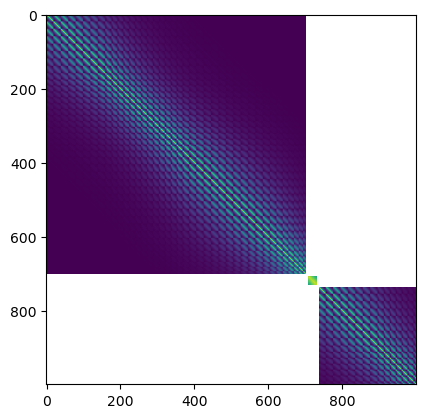

In [76]:
# build the prior covariance matrix and store it as a compresed bianry file (otherwise it can get huge!)
# depending on your machine, this may take a while...
if pf.pst.npar < 35000:  #if you have more than about 35K pars, the cov matrix becomes hard to handle
    cov = pf.build_prior(fmt='coo', filename=os.path.join(template_ws,"prior_cov.jcb"))
    # and take a peek at a slice of the matrix
    try: 
        x = cov.x.copy()
        x[x==0] = np.NaN
        plt.imshow(x[:1000,:1000])
    except:
        pass

snap!  That big block must be a grid-scale parameter group...

In [77]:
cov.row_names[:10]

['pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1',
 'pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1',
 'pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1',
 'pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1',
 'pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1',
 'pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:5_x:1375.00_y:9875.00_zone:1',
 'pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:6_x:1625.00_y:9875.00_zone:1',
 'pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:7_x:1875.00_y:9875.00_zone:1',
 'pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:8_x:2125.00_y:9875.00_zone:1',
 'pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:9_x:2375.00_y:9875.00_zone:1']

And now generate a prior parameter ensemble. This step is relevant for using pestpp-ies in subsequent tutorials. Note: you do not have to call `build_prior()` before calling `draw()`!

In [78]:
pe = pf.draw(num_reals=1000, use_specsim=True) # draw parameters from the prior distribution
pe.enforce() # enforces parameter bounds
pe.to_binary(os.path.join(template_ws,"prior_pe.jcb")) #writes the paramter ensemble to binary file
assert pe.shape[1] == pst.npar

SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
building diagonal cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['ghbcondgr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['sfrcondgr']
build cov matrix
done
getting diag var cov 40
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:15000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['npfklayer1pp']

Let's now test-run one of these geostatistical realizations (always a good idea!).  We do this by replacing the `parval1` values in the control with a row from `pe`:

In [79]:
pst.parameter_data.loc[:,"parval1"] = pe.loc[pe.index[0],pst.par_names].values
pst.parameter_data.parval1.values

array([ 0.72616096,  0.82076147,  1.08770186, ..., 30.96381582,
       29.2050304 , 45.19831249])

In [80]:
pst.control_data.noptmax = 0
pst.write(os.path.join(template_ws,"test.pst"),version=2)
pyemu.os_utils.run("pestpp-glm test.pst",cwd=template_ws)

noptmax:0, npar_adj:5410, nnz_obs:21958
pestpp-glm.exe test.pst


If all went well, that's it! The PEST-interface is setup, tested and we have our prior prepared. We should be good to go!

### Bonus: Understanding Multiplier-Parameters

Now the multiplier files in the `template_ws/mult` folder and the MF6 input files in the `template_ws` folder contain the values corresponding to this realization, so we can visualize the multiplier parameter process:

In [81]:
df = pd.read_csv(os.path.join(template_ws,"mult2model_info.csv"))
kh1_df = df.loc[df.model_file.str.contains("npf_k_layer1"),:]
kh1_df

,Unnamed: 0,org_file,model_file,use_cols,index_cols,fmt,sep,head_rows,upper_bound,lower_bound,operator,mlt_file,zone_file,apply_order,fac_file,pp_file,pp_fill_value,pp_lower_limit,pp_upper_limit,chkpar,zero_based
0,0,org\freyberg6.npf_k_layer1.txt,freyberg6.npf_k_layer1.txt,NaN,NaN,%17.1F,NaN,0,100,0.01,m,mult\npfklayer1gr_inst0_grid.csv,npfklayer1gr_inst0_grid.csv.zone,999,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1,org\freyberg6.npf_k_layer1.txt,freyberg6.npf_k_layer1.txt,NaN,NaN,%17.1F,NaN,0,100,0.01,m,mult\npfklayer1pp_inst0_pilotpoints.csv,npfklayer1pp_inst0pp.dat.zone,999,npfklayer1pp_inst0pp.fac,npfklayer1pp_inst0pp.dat,1.0,1.000000e-30,1.000000e+30,NaN,False
2,2,org\freyberg6.npf_k_layer1.txt,freyberg6.npf_k_layer1.txt,NaN,NaN,%17.1F,NaN,0,100,0.01,m,mult\npfklayer1cn_inst0_constant.csv,npfklayer1cn_inst0_constant.csv.zone,999,NaN,NaN,NaN,NaN,NaN,NaN,False


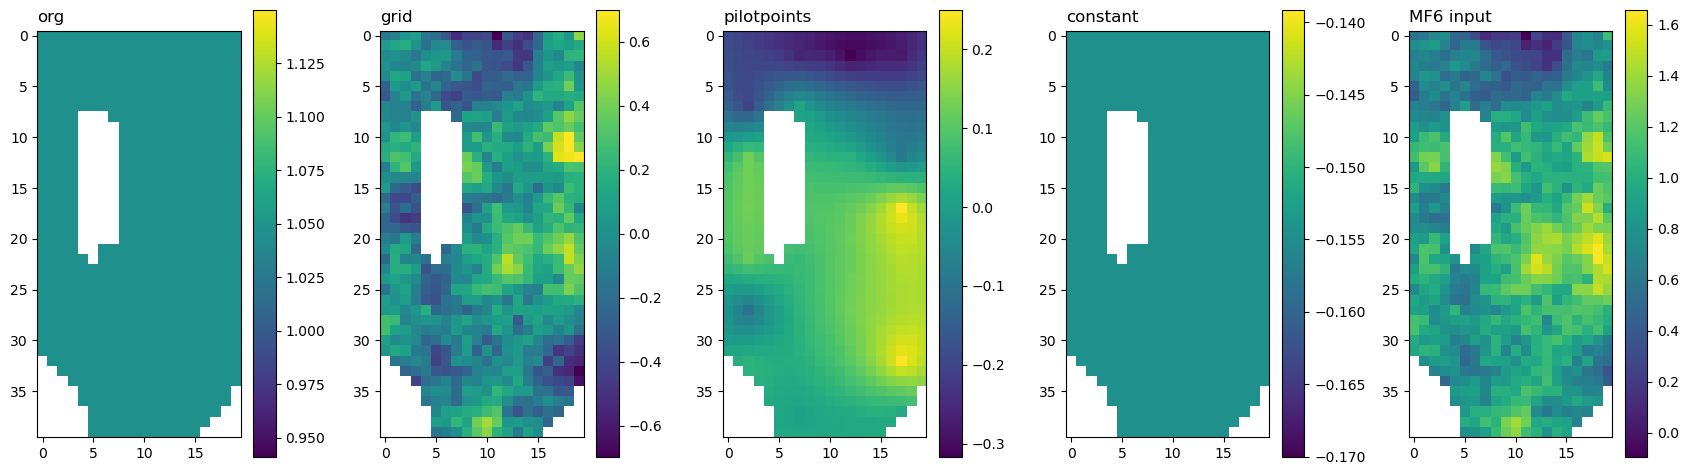

In [82]:
org_arr = np.loadtxt(os.path.join(template_ws,kh1_df.org_file.iloc[0]))
inp_arr = np.loadtxt(os.path.join(template_ws,kh1_df.model_file.iloc[0]))
mlt_arrs = [np.loadtxt(os.path.join(template_ws,afile)) for afile in kh1_df.mlt_file]
arrs = [org_arr]
arrs.extend(mlt_arrs)
arrs.append(inp_arr)
names = ["org"]
names.extend([mf.split('.')[0].split('_')[-1] for mf in kh1_df.mlt_file])
names.append("MF6 input")
fig,axes = plt.subplots(1,kh1_df.shape[0]+2,figsize=(5*kh1_df.shape[0]+2,5))
for i,ax in enumerate(axes.flatten()):
    arr = np.log10(arrs[i])
    arr[ib==0] = np.NaN
    cb = ax.imshow(arr)
    plt.colorbar(cb,ax=ax)
    ax.set_title(names[i],loc="left")
plt.tight_layout()    
    

So now we can see the difference the pilot point geostructure makes compared to the grid-scale geostructure.  The pilot point array has a much stronger spatial correlation (over a larger distance) than the grid-scale...

# Finally, what's up with all these new files and folders? We can trace through them to see how multipliers are applied

In [83]:
from IPython.display import Image, display
display(Image(url='./pest_flow2.gif'))